# Steelmaking

In order to optimize production costs, the metallurgical plant Tak Temper Steel LLC decided to reduce electricity consumption at the stage of steel processing. You have to build a model that predicts the temperature of the steel.

## Processing step description

Steel is processed in a metal ladle with a capacity of about 100 tons. In order for the ladle to withstand high temperatures, it is lined with refractory bricks from the inside. Molten steel is poured into a ladle and heated to the desired temperature with graphite electrodes. They are installed in the lid of the bucket.

Sulfur is removed from the alloy (desulfurization), the chemical composition is corrected by adding impurities, and samples are taken. Steel is alloyed - its composition is changed - by feeding pieces of alloy from a bunker for bulk materials or wire through a special tribe apparatus.

Before introducing alloying additives for the first time, the temperature of the steel is measured and its chemical analysis is carried out. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is stirred and measured again. This cycle is repeated until the target chemical composition and optimum melting temperature are reached.

Then the molten steel is sent to finish the metal or enters the continuous casting machine. From there, the finished product comes out in the form of slab blanks.

## Description of data

The data consists of files obtained from various sources:

- `data_arc.csv` — electrode data;
- `data_bulk.csv` - data on the supply of bulk materials (volume);
- `data_bulk_time.csv` *—* data on the supply of bulk materials (time);
- `data_gas.csv` — data on alloy gas purge;
- `data_temp.csv` - temperature measurement results;
- `data_wire.csv` - data on wire materials (volume);
- `data_wire_time.csv` - data on wire materials (time).

In all files, the `key` column contains the batch number. There can be several lines in files with the same `key` value: they correspond to different processing iterations.

## Data analysis

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [2]:
path ='/Users/vzuga/Documents/jupyter/datasets/final_steel/'

try:
    data_arc = pd.read_csv(path+'data_arc.csv')
    data_bulk = pd.read_csv(path+'data_bulk.csv')
    data_bulk_time = pd.read_csv(path+'data_bulk_time.csv')
    data_gas = pd.read_csv(path+'data_gas.csv')
    data_temp = pd.read_csv(path+'data_temp.csv')
    data_wire = pd.read_csv(path+'data_wire.csv')
    data_wire_time = pd.read_csv(path+'data_wire_time.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
def data_check(data):
    data.info()
    print()
    display(data.head())
    print()
    print('Duplicates:', data.duplicated().sum())
    print()
    print('Missing values')
    print(data.isna().mean())   
    print()
    print('Statistics')
    print(data.describe())

### data_arc

In [4]:
data_check(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397



Duplicates: 0

Missing values
key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64

Statistics
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034             0.637371
max     3241.000000           3.731596             2.676388


In [5]:
#incorrect value
data_arc[data_arc['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


* heating information is provided, for each batch several values indicated for different times
* fix column names
* convert dates and times to DateTime format
* emission in reactive power

### data_bulk

In [6]:
data_check(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



Duplicates: 0

Missing values
key        0.000000
Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64

Statistics
               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   4

In [7]:
#sum of all materials for each batch
data_bulk.drop(['key'], 1).sum(1).sort_values()

1731      19.0
2267      19.0
614       19.0
1708      19.0
1713      19.0
         ...  
486     1498.0
1933    1563.0
308     1569.0
1629    1757.0
303     3235.0
Length: 3129, dtype: float64

* despite the large number of passes, the total amount of bulk materials for each batch is not zero
* most likely the gaps in the values are related to the process technology

### data_bulk_time

In [8]:
data_check(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56



Duplicates: 0

Missing values
key        0.000000
Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64

Statistics
               key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000


* data is similar to data_bulk, but time is indicated instead of volume

### data_gas

In [9]:
data_check(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB



,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Duplicates: 0

Missing values
key      0.0
Газ 1    0.0
dtype: float64

Statistics
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


* указаны значения газа для каждой партии

### data_temp

In [10]:
data_check(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB



,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0



Duplicates: 0

Missing values
key             0.000000
Время замера    0.000000
Температура     0.182373
dtype: float64

Statistics
                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000


In [11]:
data_temp[data_temp['Температура'].isna()]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


* target feature
* the temperature is indicated for each batch at different points in time
* 18% misses

### data_wire

In [12]:
data_check(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Duplicates: 0

Missing values
key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64

Statistics
               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442842  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7   

In [13]:
#sum of all materials for each batch
data_wire.drop(['key'], 1).sum(1).sort_values()

1381      1.918800
3054      4.062240
3053      5.023200
135       6.158880
3051      7.119840
           ...    
1825    568.237950
1750    568.777664
2759    597.675348
2374    625.669418
2381    663.851766
Length: 3081, dtype: float64

### data_wire_time

In [14]:
data_check(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Duplicates: 0

Missing values
key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64

Statistics
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000


* data structure data_wire and data_wire_time is similar to data_bulk: time and amount of wire are specified.

### Time Analysis

I'll see what times are indicated for a particular batch, for example 7.

In [15]:
data_arc.query('key==7')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
26,7,2019-05-03 14:16:46,2019-05-03 14:18:44,0.387086,0.236391
27,7,2019-05-03 14:21:06,2019-05-03 14:27:03,1.406704,0.859944
28,7,2019-05-03 14:28:53,2019-05-03 14:30:32,0.374826,0.229962
29,7,2019-05-03 14:39:36,2019-05-03 14:41:15,0.378760,0.234998


In [16]:
data_bulk_time.query('key==7')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19


In [17]:
data_wire_time.query('key==7')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
data_temp.query('key==7')

,key,Время замера,Температура
26,7,2019-05-03 14:19:43,1586.0
27,7,2019-05-03 14:20:19,1582.0
28,7,2019-05-03 14:32:07,1599.0
29,7,2019-05-03 14:38:48,1595.0
30,7,2019-05-03 14:42:37,1599.0


It can be seen that the times of temperature measurement and other processes do not coincide.

## A list of questions

* For which point in time is it necessary to predict the temperature: for the entire batch, for each point in time, or for which specific point during one batch?
* In case of one temperature value for the whole lot, how to aggregate bulk solids and wire data? Sum or average?
* In the case of several temperature values ​​- how to associate all features with different times? And what to do with gas, it is indicated for the entire batch.

## Work plan

1. Prepare data: remove outliers, rename columns, change data type, etc.
2. Combine the data by batch and/or time value, depending on the answers to the questions.
3. Prepare features for model training (scaling, etc.).
4. Train the model, try different hyperparameters.
5. Check the model.
6. Draw conclusions.

## Data preparation

### Outliers

Find outliers in the data.

#### data_arc

I will remove the negative value in reactive power.

array([[<AxesSubplot:title={'center':'Активная мощность'}>,
        <AxesSubplot:title={'center':'Реактивная мощность'}>]],
      dtype=object)

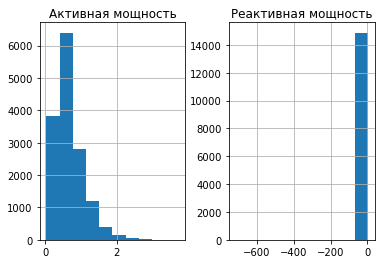

In [19]:
data_arc[['Активная мощность', 'Реактивная мощность']].hist()

In [20]:
data_arc.query('`Реактивная мощность`<0')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [21]:
data_arc = data_arc.query('`Реактивная мощность`>0')

array([[<AxesSubplot:title={'center':'Активная мощность'}>,
        <AxesSubplot:title={'center':'Реактивная мощность'}>]],
      dtype=object)

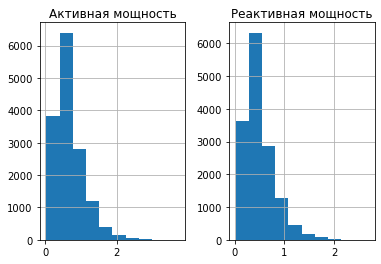

In [22]:
data_arc[['Активная мощность', 'Реактивная мощность']].hist()

In [23]:
data_arc[['Активная мощность', 'Реактивная мощность']].corr()

,Активная мощность,Реактивная мощность
Активная мощность,1.000000,0.963182
Реактивная мощность,0.963182,1.000000


Active power is strongly correlated with reactive power.

#### data_bulk
I will check the values in bulk materials.

<AxesSubplot:>

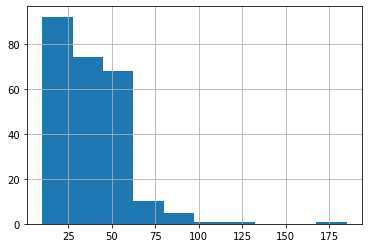

In [24]:
data_bulk['Bulk 1'].hist()

<AxesSubplot:>

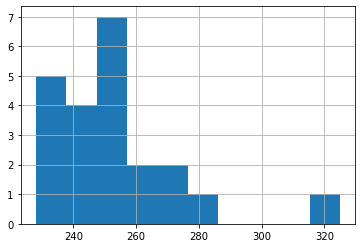

In [25]:
data_bulk['Bulk 2'].hist()

<AxesSubplot:>

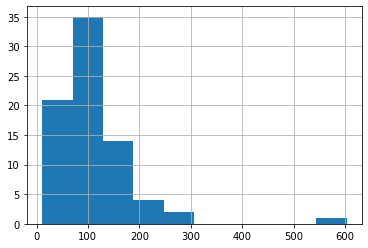

In [26]:
data_bulk['Bulk 5'].hist()

<AxesSubplot:>

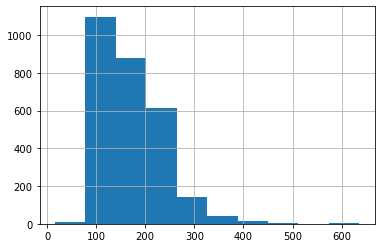

In [27]:
data_bulk['Bulk 14'].hist()

<AxesSubplot:>

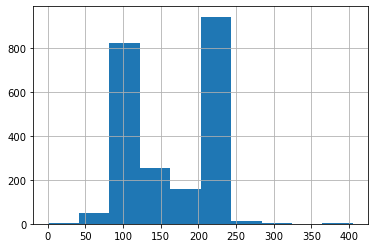

In [28]:
data_bulk['Bulk 15'].hist()

I will select data with too large values.

In [29]:
bulk_out = data_bulk.query(
    '`Bulk 12`>800 or `Bulk 1`>150 or `Bulk 2`>300 or `Bulk 5`>500 or `Bulk 14`>550 or `Bulk 15`>350'
)
bulk_out

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
104,117,52.0,325.0,NaN,68.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN
560,589,NaN,NaN,NaN,133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,460.0,NaN,258.0,405.0
561,590,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,409.0,NaN,255.0,405.0
1747,1808,NaN,NaN,226.0,30.0,603.0,NaN,NaN,NaN,NaN,NaN,NaN,210.0,NaN,99.0,104.0
1755,1816,62.0,NaN,NaN,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,833.0,NaN,249.0,NaN
1774,1836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,601.0,103.0
1933,1999,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,853.0,NaN,366.0,290.0
2755,2858,NaN,NaN,NaN,NaN,NaN,152.0,NaN,NaN,NaN,NaN,NaN,208.0,NaN,552.0,52.0


#### data_gas

<AxesSubplot:>

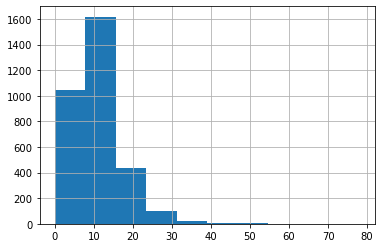

In [30]:
data_gas['Газ 1'].hist()

In [31]:
#too big values
gas_out = data_gas.query('`Газ 1`>50')
gas_out

,key,Газ 1
116,117,50.581035
277,280,60.935689
319,322,77.995040
2107,2110,52.142373
2567,2570,51.380229


#### data_temp

<AxesSubplot:>

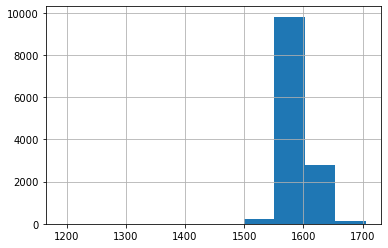

In [32]:
data_temp['Температура'].hist()

In [33]:
temp_out = data_temp.query('`Температура`<1500')
temp_out

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


#### data_wire

array([[<AxesSubplot:title={'center':'Wire 1'}>,
        <AxesSubplot:title={'center':'Wire 2'}>]], dtype=object)

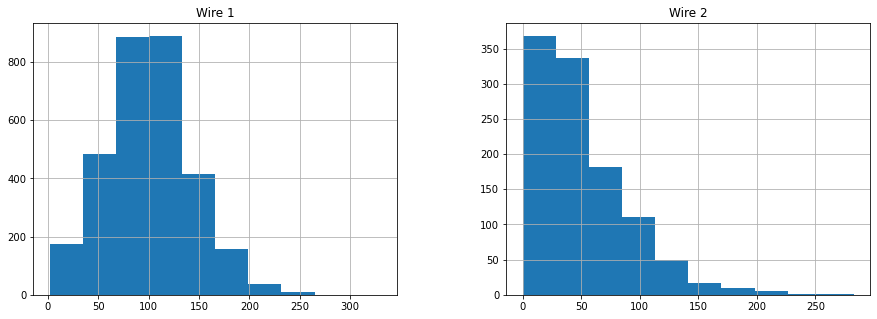

In [34]:
data_wire[['Wire 1', 'Wire 2']].hist(figsize=(15, 5))

In [35]:
wire_out = data_wire.query('`Wire 1`>250 or `Wire 2`>250')
wire_out

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1201,1269,142.365600,282.780152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1392,1464,280.987214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1732,1821,330.314424,69.337838,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I will collect all batch numbers with outliers in one file so that after combining the data, outliers can be excluded.

Based on the simulation results, I decided not to remove these outliers.

In [36]:
outliers = pd.concat([bulk_out.key, gas_out.key, temp_out.key, wire_out.key], ignore_index=True)
#removing duplicates
outliers = outliers.drop_duplicates().reset_index(drop=True)

### Dates and column names

In [37]:
#data_arc
data_arc.columns = ['key', 'start', 'end','active_power', 'reactive_power']

data_arc[['start', 'end']] = data_arc[['start', 'end']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

In [38]:
#data_bulk
data_bulk.columns = ['key', 'Bulk_1', 'Bulk_2', 'Bulk_3', 'Bulk_4', 'Bulk_5', 'Bulk_6',
       'Bulk_7', 'Bulk_8', 'Bulk_9', 'Bulk_10', 'Bulk_11', 'Bulk_12',
       'Bulk_13', 'Bulk_14', 'Bulk_15']
data_bulk.columns = data_bulk.columns.str.lower()

In [39]:
#data_bulk_time
data_bulk_time.columns = ['key', 'Bulk_1', 'Bulk_2', 'Bulk_3', 'Bulk_4', 'Bulk_5', 'Bulk_6',
       'Bulk_7', 'Bulk_8', 'Bulk_9', 'Bulk_10', 'Bulk_11', 'Bulk_12',
       'Bulk_13', 'Bulk_14', 'Bulk_15']
data_bulk_time.columns = data_bulk_time.columns.str.lower()

data_bulk_time.iloc[:,1:16] = data_bulk_time.iloc[:,1:16].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

In [40]:
#data_gas
data_gas.columns = ['key', 'gas']

In [41]:
#data_temp
data_temp.columns = ['key', 'time', 'temp']

data_temp['time'] = pd.to_datetime(data_temp['time'], format='%Y-%m-%d %H:%M:%S')

In [42]:
#data_wire
data_wire.columns = ['key', 'Wire_1', 'Wire_2', 'Wire_3', 'Wire_4', 'Wire_5', 'Wire_6',
       'Wire_7', 'Wire_8', 'Wire_9']
data_wire.columns = data_wire.columns.str.lower()

In [43]:
#data_wire_time
data_wire_time.columns = ['key', 'Wire_1', 'Wire_2', 'Wire_3', 'Wire_4', 'Wire_5', 'Wire_6',
       'Wire_7', 'Wire_8', 'Wire_9']
data_wire_time.columns = data_wire_time.columns.str.lower()

data_wire_time.iloc[:,1:10] = data_wire_time.iloc[:,1:10].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

### Missing values

I will fill in the gaps in bulk materials and wire with zeros, since Nan in this case is not the absence of data, but the absence of wire or bulk materials in the production process itself.

In [44]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

### Checking the temperature measurement time

In each batch, the temperature is measured several times. The batch end temperature is required for prediction. I will check that the temperature was measured after heating and alloying. To do this, you need to make sure that the temperature measurement time is the last (longest) in each batch. Thus, the “correct” temperature will fall into the target feature for training the model.

In [45]:
#eliminate gaps in temperature measurements
data_temp = data_temp[data_temp['temp'].notna()]

In [46]:
#get the latest (maximum) times for each process
temp_time = data_temp.groupby('key')['time'].max()
arc_time = data_arc.groupby('key')['end'].max()
bulk_time = data_bulk_time.set_index('key').max(axis=1)
wire_time = data_wire_time.set_index('key').max(axis=1)

#concatenate into one df
key_time = pd.concat([temp_time, arc_time, bulk_time, wire_time], axis=1)
key_time.columns = ['temp_measurement', 'arc', 'bulk', 'wire']
key_time = key_time.reset_index()
key_time.head()

,key,temp_measurement,arc,bulk,wire
0,1,2019-05-03 11:30:39,2019-05-03 11:28:37,2019-05-03 11:21:30,2019-05-03 11:11:41
1,2,2019-05-03 11:59:12,2019-05-03 11:53:18,2019-05-03 11:46:38,2019-05-03 11:46:10
2,3,2019-05-03 12:34:57,2019-05-03 12:32:19,2019-05-03 12:31:06,2019-05-03 12:13:47
3,4,2019-05-03 12:59:25,2019-05-03 12:57:50,2019-05-03 12:48:43,2019-05-03 12:48:05
4,5,2019-05-03 13:36:01,2019-05-03 13:33:55,2019-05-03 13:18:50,2019-05-03 13:32:06


In [47]:
#temperature not measured at the end of the batch
time_out = key_time[
    (key_time['temp_measurement']<key_time['arc'])|(
        key_time['temp_measurement']<key_time['bulk'])|(
        key_time['temp_measurement']<key_time['wire'])
]
#time_out = key_time[(key_time['temp_measurement']<key_time['arc'])]
time_out.head()

,key,temp_measurement,arc,bulk,wire
10,11,2019-05-03 17:27:23,2019-05-03 17:29:07,2019-05-03 17:16:34,2019-05-03 17:15:01
37,38,2019-05-04 16:26:37,2019-05-04 16:27:24,2019-05-04 16:20:16,2019-05-04 16:17:14
40,43,2019-05-04 20:48:10,2019-05-04 20:49:31,2019-05-04 20:34:07,2019-05-04 20:33:21
48,51,2019-05-05 06:10:21,2019-05-05 06:11:30,NaT,NaT
61,64,2019-05-05 17:26:46,2019-05-05 17:28:20,2019-05-05 16:45:05,2019-05-05 16:44:30


In [48]:
#attach incorrect temperature measurements to outliers

#outliers = pd.concat([outliers, time_out.key], ignore_index=True)

#I will delete only the wrong temperature
outliers = time_out.key

#drop duplicates
outliers = outliers.drop_duplicates().reset_index(drop=True)
outliers

0        11
1        38
2        43
3        51
4        64
       ... 
868    3237
869    3238
870    3239
871    3240
872    3241
Name: key, Length: 873, dtype: int64

The result is a list of parties that I will exclude when training the model.

## Data concatenation

To begin with, I aggregate the data for each batch.

In [49]:
#calculate total power
data_arc['power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)

Since all power correlate with each other, I will calculate the total power per batch and see which value is more suitable for modeling.

In [50]:
#heat data grouping
arc_grouped = data_arc.groupby('key').sum()

#arc_grouped = data_arc.groupby('key').max()

#arc_grouped = data_arc.groupby('key').apply(
    #lambda x: x.loc[x['end'].idxmax(), ['active_power', 'reactive_power', 'power']]).reset_index()

In [51]:
#temperature grouping
temp_grouped = data_temp.groupby('key').apply(lambda x: x.loc[x['time'].idxmax(), 'temp']).reset_index()

In [52]:
#exclude parties with outliers and incorrect temperature measurements
temp_grouped = temp_grouped.query('key not in @outliers')
temp_grouped.columns=['key', 'temp']
temp_grouped

,key,temp
0,1,1613.0
1,2,1602.0
2,3,1599.0
3,4,1625.0
4,5,1602.0
...,...,...
2473,2496,1591.0
2474,2497,1589.0
2475,2498,1594.0
2476,2499,1603.0


In [53]:
df = temp_grouped.merge(arc_grouped, how='left', on='key')
df = df.merge(data_bulk, how='left', on='key')
df = df.merge(data_gas, how='left', on='key')
df = df.merge(data_wire, how='left', on='key')

In [54]:
df.isna().sum()

key                0
temp               0
active_power       2
reactive_power     2
power              2
bulk_1            63
bulk_2            63
bulk_3            63
bulk_4            63
bulk_5            63
bulk_6            63
bulk_7            63
bulk_8            63
bulk_9            63
bulk_10           63
bulk_11           63
bulk_12           63
bulk_13           63
bulk_14           63
bulk_15           63
gas                2
wire_1            96
wire_2            96
wire_3            96
wire_4            96
wire_5            96
wire_6            96
wire_7            96
wire_8            96
wire_9            96
dtype: int64

There are a small number of omissions due to lack of information on some batches. It makes no sense to fill them with zeros. Since there are few gaps, I will delete this data.

In [55]:
df = df.dropna()
#df = df.fillna(0)

In [56]:
df.head()

,key,temp,active_power,reactive_power,power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1613.0,4.878147,3.183241,5.826395,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1602.0,3.052598,1.998112,3.649216,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1599.0,2.525882,1.599076,2.989534,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1625.0,3.209250,2.060298,3.814962,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1602.0,3.347173,2.252643,4.035758,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Features

In [57]:
features = df.drop(['key','temp'], axis=1)
features = features.drop(['power', 'reactive_power'], 1)
target = df['temp']
#scaler = StandardScaler()
#features = scaler.fit_transform(features)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, random_state=1234)

## Model Training

In [58]:
model = CatBoostRegressor(verbose=1000, learning_rate=0.016, loss_function='MAE', iterations=1700, depth=3)
mae = -1*cross_val_score(model, features_train, target_train, cv=3, scoring='neg_mean_absolute_error')
model.fit(features_train, target_train)
print('MAE on the training sample:', np.mean(mae))

0:	learn: 7.9857921	total: 57.9ms	remaining: 1m 38s
1000:	learn: 5.6219773	total: 507ms	remaining: 354ms
1699:	learn: 5.2564052	total: 823ms	remaining: 0us
0:	learn: 8.1637923	total: 609us	remaining: 1.03s
1000:	learn: 5.9061569	total: 472ms	remaining: 329ms
1699:	learn: 5.5106687	total: 805ms	remaining: 0us
0:	learn: 7.9676944	total: 518us	remaining: 882ms
1000:	learn: 5.6678707	total: 457ms	remaining: 319ms
1699:	learn: 5.3126523	total: 782ms	remaining: 0us
0:	learn: 8.0382481	total: 778us	remaining: 1.32s
1000:	learn: 5.9661204	total: 528ms	remaining: 369ms
1699:	learn: 5.6581128	total: 898ms	remaining: 0us
MAE on the training sample: 6.84518670165903


In [59]:
#parameters = {'depth':[2, 3, 7], 'learning_rate':[0.01, 0.015, 0.016, 0.017], 'iterations':[1000, 1500]}
#model = CatBoostRegressor(verbose=1000, loss_function='MAE')
#grid = GridSearchCV(estimator=model, param_grid=parameters, cv=3, scoring='neg_mean_absolute_error')
#grid.fit(features_train, target_train)
#print('MAE:', grid.best_score_)
#print('Параметры:', grid.best_params_)

I will look at the contribution of various features to the model.

Top 5 featurea:
 active_power    27.546841
wire_1          12.020545
bulk_6           9.878724
wire_2           9.046308
bulk_14          7.212353
dtype: float64


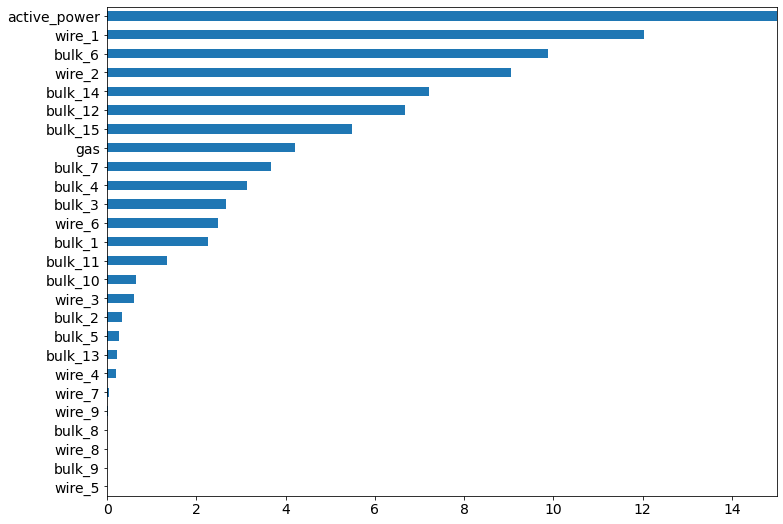

In [60]:
importances = pd.Series(model.feature_importances_, index=features_train.columns).sort_values()
importances.plot(kind='barh', figsize=(12,9), xlim=(0, 15), fontsize=14)
print('Top 5 featurea:\n', importances.sort_values(ascending=False).head())

I will remove the last five features from the model.

In [61]:
features = df.drop(['key','temp'], axis=1)
features = features.drop(['power', 'reactive_power', 'wire_9', 'bulk_8', 'wire_8', 'wire_5', 'bulk_9'], 1)
target = df['temp']
#scaler = StandardScaler()
#features = scaler.fit_transform(features)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, random_state=1234)

model = CatBoostRegressor(verbose=1000, learning_rate=0.016, loss_function='MAE', iterations=1700, depth=3)
model.fit(features_train, target_train)
mae = -1*cross_val_score(model, features_train, target_train, cv=3, scoring='neg_mean_absolute_error')
print('MAE on the training sample:', np.mean(mae))

0:	learn: 8.0401248	total: 695us	remaining: 1.18s
1000:	learn: 5.9537283	total: 521ms	remaining: 364ms
1699:	learn: 5.6576255	total: 879ms	remaining: 0us
0:	learn: 7.9904092	total: 1.35ms	remaining: 2.29s
1000:	learn: 5.6428703	total: 437ms	remaining: 305ms
1699:	learn: 5.2752496	total: 754ms	remaining: 0us
0:	learn: 8.1670126	total: 626us	remaining: 1.06s
1000:	learn: 5.9214426	total: 453ms	remaining: 316ms
1699:	learn: 5.5193358	total: 762ms	remaining: 0us
0:	learn: 7.9698848	total: 421us	remaining: 715ms
1000:	learn: 5.6892215	total: 459ms	remaining: 320ms
1699:	learn: 5.3295288	total: 780ms	remaining: 0us
MAE on the training sample: 6.845706448521507


## Model validation

In [62]:
mae_test = mean_absolute_error(target_test, model.predict(features_test))
print('MAE on the test sample:', mae_test)

MAE on the test sample: 6.754291003867306


## Conclusions

* a model was built that predicts the temperature of steel
* as a result of the simulation, the MAE value was equal to 6.8
* there are a lot of missing values ​​in the features, because of this, the metric on the test sample may change
* removal of features with a large number of gaps degrades the quality of the model

# Report

_In your report, answer the following questions:_

- _Which points of the plan were completed and which were not (explain why)?_

- _What difficulties arose and how did you overcome them?_

- _What are the key steps in solving the problem?_

- _What is your final model and what is its quality?_

A model was built to predict the temperature of steel at the stage of metal processing.

Before starting work, a plan was formulated. Some of the original tasks in the plan had to be abandoned:
* __removal of outliers__ - when deleting, the accuracy of the model fell,
* __feature scaling__ - not needed, model accuracy has not changed.

As part of the initial analysis of the problem, two main questions arose:
1. How to extract a key feature, temperature, from the data?
2. Based on the first question, how to perform data aggregation? What about heating power?

A more detailed description of the technological process and the answer to the first question was provided by the team leader. The answer to the second question was obtained experimentally. I tried to calculate the average and the sum - with the sum I managed to achieve higher accuracy.

Another difficulty was having features with a large number of gaps and estimating their impact on the model, as well as estimating outliers. After analyzing the contribution of factors, some features were removed from the model. Perhaps by reducing the number of gaps by increasing the sample, better predictions can be achieved.

To quickly evaluate various factors and reduce computation time, I initially used a linear regression model, which I later replaced with CatBoost with a selection of optimal hyperparameters. The final MAE metric was 6.75 on the test set.